In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json
import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

/anaconda3/envs/py36/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from sklearn.metrics import average_precision_score

In [4]:
df = pd.read_csv('../data/nyt_comment_sample.csv', sep = '|', error_bad_lines=False)

In [11]:
df_ml = df[['replyCount', 'recommendationCount', 'createDate', 'commentBody','editorsSelection']]
df_ml = df_ml.sample(frac=1)
df_ml = df_ml.dropna()

In [12]:
nltk_regex = nltk.RegexpTokenizer('\w+')
def word_count(text):
    return len(nltk_regex.tokenize(text.lower()))

In [13]:
sid = SentimentIntensityAnalyzer()

df_ml['neg'] = df_ml['commentBody'].apply(lambda x: sid.polarity_scores(str(x))['neg'])
df_ml['pos'] = df_ml['commentBody'].apply(lambda x: sid.polarity_scores(str(x))['pos'])

In [14]:
df_ml['word_count'] = df_ml['commentBody'].apply(lambda x : word_count(str(x)))

In [21]:
df_X = df_ml[['replyCount', 'recommendationCount', 'createDate', 'commentBody','neg','pos', 'word_count']]
df_Y = df_ml[['editorsSelection']]


X_train, X_test, y_train, y_test =train_test_split(df_X, df_Y, 
                                                   test_size=0.1, random_state=0, stratify=y)

In [22]:
X_train.head()

,replyCount,recommendationCount,createDate,commentBody,neg,pos,word_count
70026,0,0,2015-03-30 20:49:08,Please do a key word search on Mortgage Electr...,0.027,0.050,88
90076,0,0,2015-04-01 19:12:41,We ain't.,0.000,0.000,3
95510,0,0,2015-04-02 13:47:30,And now the Arab Joint List is the third large...,0.056,0.116,47
57953,0,1,2015-03-28 20:08:03,Thank you for posting your comment. I beli...,0.156,0.055,263
38923,1,7,2015-03-26 13:11:13,What's wrong with 'paramour' for either a man ...,0.067,0.156,45


Directly use pipeline of vect, tfidf, and clfs doesn't output decent performance

precision_score = 0.0

Pipeline([('vect', CountVectorizer(ngram_range=(1,3), min_df=2, stop_words="english")), 
                           ('tfidf', TfidfTransformer()),MultinomialNB()])

### Using the random sampler to downsample and create voting classifier

In [7]:
from imblearn.ensemble import BalancedBaggingClassifier

In [10]:
import nltk.stem

english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

In [16]:
text_preprocess = Pipeline([('vect', StemmedCountVectorizer(ngram_range=(1,3), min_df=10, stop_words="english")), 
                            ('tfidf', TfidfTransformer())])

In [23]:
tf_vect_tfidf = text_preprocess.fit_transform(X_train['commentBody'].values.astype('U'))

In [24]:
X_train['hour'] = pd.to_datetime(X_train['createDate']).dt.hour

In [26]:
from scipy import sparse

In [27]:
num_feats = X_train[[ "neg", "pos","word_count","hour", 'replyCount', 'recommendationCount']].astype(float).values
train_data = sparse.hstack((tf_vect_tfidf, num_feats))

In [28]:
tf_vect_tfidf_test = text_preprocess.transform(X_test['commentBody'].values.astype('U'))

In [30]:
X_test['hour'] = pd.to_datetime(X_test['createDate']).dt.hour

In [31]:
num_feats_test = X_test[["neg", "pos","word_count","hour", 'replyCount', 'recommendationCount']].astype(float).values
testing_data = sparse.hstack((tf_vect_tfidf_test, num_feats_test))

In [42]:
from sklearn.metrics import f1_score

Naive Bayes

In [32]:
bbc = BalancedBaggingClassifier(base_estimator= MultinomialNB(), replacement = True)
bbc.fit(train_data, y_train)

BalancedBaggingClassifier(base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
             random_state=None, ratio='auto', replacement=True, verbose=0,
             warm_start=False)

In [33]:
y_pred = bbc.predict(testing_data)

In [35]:
pred = bbc.predict_proba(testing_data)
metrics.average_precision_score(y_test, pred[:, 1])

0.12825855839445313

In [36]:
average_precision = metrics.average_precision_score(y_test, pred[:, 1])

In [37]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(8756, 1041, 82, 121)

In [44]:
f1_score(y_test, y_pred)

0.1772893772893773

In [38]:
from sklearn.metrics import precision_recall_curve

Text(0.5,1,'2-class Precision-Recall curve: AP=0.13')

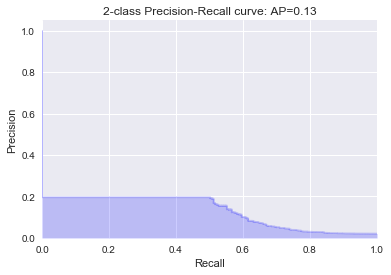

In [39]:
precision, recall, _ = precision_recall_curve(y_test, pred[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

linear support vector machine (SVM)

In [40]:
bbc_SVM = BalancedBaggingClassifier(base_estimator= SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42,
                                            max_iter=5, tol=None))
bbc_SVM.fit(train_data, y_train)

BalancedBaggingClassifier(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
             random_state=None, ratio='auto', replacement=False, verbose=0,
             warm_start=False)

In [41]:
pred_svm = bbc_SVM.predict_proba(testing_data)
metrics.average_precision_score(y_test, pred_svm[:, 1])

0.10826149157162354

In [45]:
average_precision = metrics.average_precision_score(y_test, pred_svm[:, 1])

In [46]:
y_pred_svm = bbc_SVM.predict(testing_data)

In [54]:
f1_score(y_test, y_pred_svm)

0.18018018018018017

In [47]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_svm).ravel()
(tn, fp, fn, tp)

(8687, 1110, 73, 130)

Text(0.5,1,'2-class Precision-Recall curve: AP=0.11')

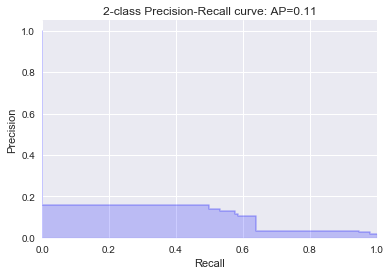

In [48]:
precision, recall, _ = precision_recall_curve(y_test, pred_svm[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Random Forest

In [50]:
rf = RandomForestClassifier(n_estimators=400, class_weight = 'balanced')

rf.fit(train_data, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
pred_rf = rf.predict_proba(testing_data)
metrics.average_precision_score(y_test, pred_rf[:, 1])

0.29289306526575976

In [52]:
y_pred_rf = rf.predict(testing_data)

In [53]:
f1_score(y_test, y_pred_rf)

0.08450704225352114

In [55]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_rf).ravel()
(tn, fp, fn, tp)

(9796, 1, 194, 9)

In [56]:
average_precision = metrics.average_precision_score(y_test, pred_rf[:, 1])

Text(0.5,1,'2-class Precision-Recall curve: AP=0.29')

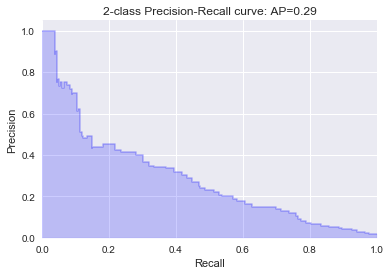

In [57]:
precision, recall, _ = precision_recall_curve(y_test, pred_rf[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

LinSVC

In [60]:
from sklearn.svm import LinearSVC

In [62]:
bbc_linSVC = BalancedBaggingClassifier(base_estimator= LinearSVC(), replacement = True)

bbc_linSVC.fit(train_data, y_train)

BalancedBaggingClassifier(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
             random_state=None, ratio='auto', replacement=True, verbose=0,
             warm_start=False)

In [63]:
pred_linSVC = bbc_linSVC.predict_proba(testing_data)
metrics.average_precision_score(y_test, pred_linSVC[:, 1])

0.1902724821617621

In [64]:
average_precision = metrics.average_precision_score(y_test, pred_linSVC[:, 1])

In [65]:
y_pred_linSVC = bbc_linSVC.predict(testing_data)

In [66]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_linSVC).ravel()
(tn, fp, fn, tp)

(9164, 633, 71, 132)

In [67]:
f1_score(y_test, y_pred_linSVC)

0.27272727272727276

Text(0.5,1,'2-class Precision-Recall curve: AP=0.19')

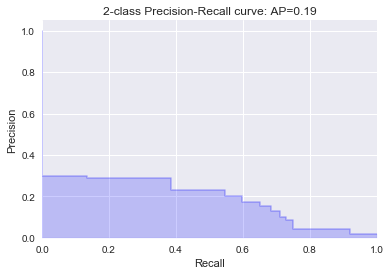

In [68]:
precision, recall, _ = precision_recall_curve(y_test, pred_linSVC[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [70]:
bbc_log = BalancedBaggingClassifier(base_estimator= LogisticRegression(), replacement = True)

bbc_log.fit(train_data, y_train)

BalancedBaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
             random_state=None, ratio='auto', replacement=True, verbose=0,
             warm_start=False)

In [71]:
pred_log = bbc_log.predict_proba(testing_data)
metrics.average_precision_score(y_test, pred_log[:, 1])

0.24990660537288772

In [72]:
average_precision = metrics.average_precision_score(y_test, pred_log[:, 1])

In [73]:
y_pred_log = bbc_log.predict(testing_data)

In [74]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_log).ravel()
(tn, fp, fn, tp)

(8808, 989, 59, 144)

In [75]:
f1_score(y_test, y_pred_log)

0.21556886227544905

Text(0.5,1,'2-class Precision-Recall curve: AP=0.25')

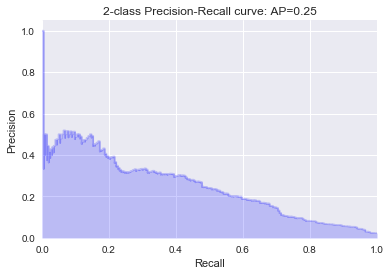

In [76]:
precision, recall, _ = precision_recall_curve(y_test, pred_log[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [77]:
from mlxtend.classifier import StackingClassifier

In [79]:
clf1 = BalancedBaggingClassifier(base_estimator= LogisticRegression(), replacement = True)
clf2 = BalancedBaggingClassifier(base_estimator= SGDClassifier(), replacement = True)
clf3 = BalancedBaggingClassifier(base_estimator= LinearSVC(), replacement = True)
clf4 = RandomForestClassifier(n_estimators=400, class_weight = 'balanced')
clf5 = BalancedBaggingClassifier(base_estimator= MultinomialNB(), replacement = True)

lr = BalancedBaggingClassifier(base_estimator= LogisticRegression(), replacement = True)

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5],
                          use_probas=True,
                          meta_classifier=lr)

sclf.fit(train_data, y_train)

StackingClassifier(average_probas=False,
          classifiers=[BalancedBaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0,...       random_state=None, ratio='auto', replacement=True, verbose=0,
             warm_start=False)],
          meta_classifier=BalancedBaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose...        random_state=None, ratio='auto', replacement=True, verbose=0,
             warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=True, verbose=0

In [80]:
pred_sclf = sclf.predict_proba(testing_data)
metrics.average_precision_score(y_test, pred_sclf[:, 1])

0.327006080286077

In [81]:
average_precision = metrics.average_precision_score(y_test, pred_sclf[:, 1])

In [82]:
y_pred_sclf = sclf.predict(testing_data)

In [83]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_sclf).ravel()
(tn, fp, fn, tp)

(9796, 1, 194, 9)

In [84]:
f1_score(y_test, y_pred_sclf)

0.08450704225352114

Text(0.5,1,'2-class Precision-Recall curve: AP=0.33')

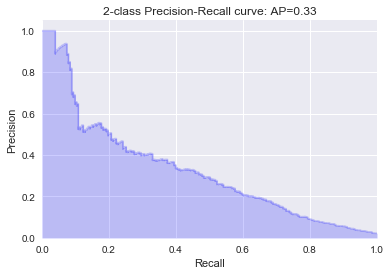

In [85]:
precision, recall, _ = precision_recall_curve(y_test, pred_sclf[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))